In [1]:

import process_gens
import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import ProcessGens
num_beams_list=[1]
models=["meta_llama_Llama_3.1_8B_Instruct"]
eval_instances=12
task_name="wmt_14_language_pair_de_en_"
root_folder=f"snellius_copies/helm_output"
suite_name="sample_return_eval_20"
# instance_metrics=["comet"]
instance_metrics=[]

custom_metrics=[ PostMetric.BLEU1_METRIC(),PostMetric.BLEU4_METRIC()]
processGens= ProcessGens(root_folder=root_folder,num_beams_list=num_beams_list,models=models,custom_metrics=custom_metrics,task_name=task_name, eval_instances=eval_instances, instance_metrics=instance_metrics, suite_name=suite_name)


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


get_metrics_df
get_instance_info
Getting gen summary from: snellius_copies/helm_output/sample_return_eval_20/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_return_eval_20/generation_summary_metrics.json
Analyzing path: snellius_copies/helm_output/sample_return_eval_20/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_return_eval_20/per_instance_stats.json
calculate_beam_num_to_summary
Getting gen summary from: snellius_copies/helm_output/sample_return_eval_20/wmt_14_language_pair_de_en_/meta_llama_Llama_3.1_8B_Instruct/1_beams/runs/sample_return_eval_20/generation_summary_metrics.json
number of instances: 12
get_metrics_dict
1


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

In [2]:

from process_gen_utils import *
print(f"eval_instances {eval_instances}")
print(f"sum(num_beams_list) {sum(num_beams_list)}")
examples_df, completions_df=get_dfs(processGens, eval_instances, num_beams_list)


eval_instances 12
sum(num_beams_list) 1
Index(['comet_score', 'text', 'completion_length', 'output_logprob',
       'instanceID', 'isCompletion', 'BLEU_1', 'BLEU_4', 'beam_num'],
      dtype='object')
Num examples: 240
Num completions: 12


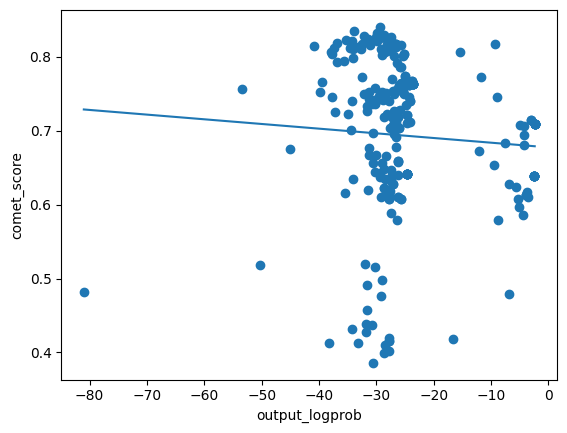

In [4]:
# examples_df
plot_keys(df=examples_df, xlabel='output_logprob', ylabel='comet_score')

In [5]:
for col in ['comet_score', 'output_logprob']:
    examples_df[col + '_norm'] = examples_df.groupby('instanceID')[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

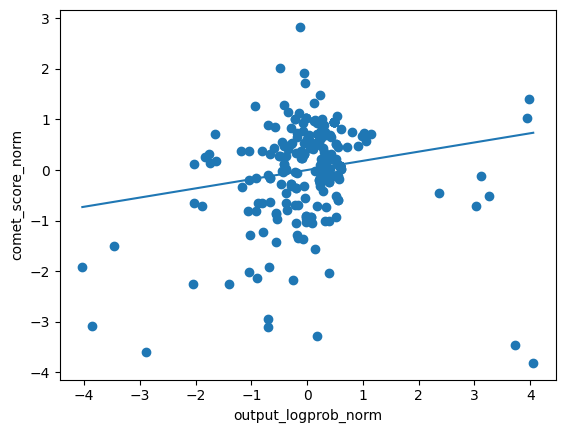

In [6]:
plot_keys(df=examples_df, xlabel='output_logprob_norm', ylabel='comet_score_norm')